<a href="https://colab.research.google.com/github/Satwikram/Pneumonia-Detection-using-Vision-Transformers/blob/main/Notebooks/Pneumonia%20Detection%20using%20Vision%20Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

Pneumonia Detection

![alt text](https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2016/05/18/13/02/ww5r032t-8col-jpg.jpg)

**Pneumonia Detection using 6000 Chest X-Ray HD Images.**
[link text](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


**Chest X-Ray of Infected Person**![alt text](https://radiologyassistant.nl/assets/chest-x-ray-lung-disease/a51a0976c3619b_TAB-density-new.jpg)

**Chest X-Ray of healthy Person**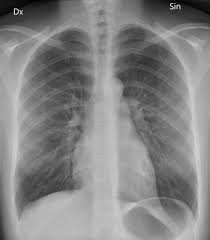

### Setup

In [ ]:
!pip install transformers
!pip install livelossplot

### Connecting to Kaggle

In [23]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


### Downloading Dataset

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
!unzip /content/chest-xray-pneumonia.zip

### Importing Dependencies

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re

import os
from pathlib import Path

import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling1D, BatchNormalization, Embedding, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard



from sklearn.model_selection import train_test_split

from unicodedata import normalize

from tqdm import tqdm

from PIL import Image

from transformers import ViTFeatureExtractor, TFViTForImageClassification

import plotly.express as px
from datetime import date

from sklearn.metrics import *

import joblib

from livelossplot import PlotLossesKeras

### Global Variables

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224 #Setting all the images to 224 pixels

### Function to get data

In [3]:
def get_data(data_dir):

  
  data = []

  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    
    count = 0

    for img in os.listdir(path):
      if count <= 200:
        try:
          img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
          img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
          resized_array = cv2.resize(img_array, (img_size, img_size))
      
          resized_array = resized_array / 255

          data.append([resized_array, class_num])

        except Exception as e:
          pass
        
        count += 1

  return data

In [4]:
# Getting train data
train = get_data('chest_xray/train')

# Getting test data
test = get_data('chest_xray/test')

# Getting Validadtion Data
val = get_data('chest_xray/val')

### Counting total numbers of images

In [5]:
def count(data):
  pneumonia = 0 
  normal = 0 

  for i, j in data:
    if j == 0:
      pneumonia += 1

    else:
      normal += 1

  print("Pneumonia Images:", pneumonia)
  print("Normal Images:", normal)
  print("Total Images:", pneumonia + normal)

In [6]:
count(train)

Pneumonia Images: 201
Normal Images: 201
Total Images: 402


In [7]:
count(test)

Pneumonia Images: 201
Normal Images: 201
Total Images: 402


In [8]:
count(val)

Pneumonia Images: 8
Normal Images: 8
Total Images: 16


### Taking X and Y

In [9]:
X = []
y = []

# For training data
for feature, label in train:
  X.append(feature)
  y.append(label)


# For test data
for feature, label in test:
  X.append(feature)
  y.append(label)


# X = np.array(X).reshape(-1, img_size, img_size, 1)
# X = np.array(X)
y = np.array(y)

# X = X / 255

### Shuffel the data and split the data into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle=True, stratify=y)

### Feature Extraction

In [11]:
checkpoint = "google/vit-base-patch16-224"

In [12]:
def feature_extraction(samples):
  
  feature_extractor = ViTFeatureExtractor.from_pretrained(checkpoint)

  return feature_extractor(samples, return_tensors="np")["pixel_values"]

In [13]:
X_train[0].shape

(224, 224, 3)

In [16]:
X_train = feature_extraction(X_train)
X_test = feature_extraction(X_test)

### Building the model

In [19]:
def build_model(targets, checkpoint, input_shape):

  base_model = TFViTForImageClassification.from_pretrained(checkpoint)

  pixel_values = Input(shape=input_shape, name="pixel_values")

  x = base_model.vit(pixel_values=pixel_values)[0]

  x = Flatten()(x)

  units = len(np.unique(targets))

  if units > 2:
      activation = "softmax"
      loss = "sparse_categorical_crossentropy"
  else:
      activation = "sigmoid"
      loss = "binary_crossentropy"
      units = units - 1

  outputs = Dense(units, activation = activation, name = "outputs")(x)

  model = Model(inputs=pixel_values, outputs=outputs)

  optimizer =  tf.keras.optimizers.Adam()

  model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

  # Model Architecture Export
  tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, 
                          show_dtype=True, show_layer_names=True, rankdir='TB',
                          expand_nested=True, dpi=300, layer_range=None, 
                          show_layer_activations=True)

  return model

In [20]:
model = build_model(y_train, checkpoint, X_train[0].shape)

Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at google/vit-base-patch16-224.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


### Callbacks

In [27]:
def callbacks() -> list:

    run_name = "run 1"
    save_path = Path("models")
    os.makedirs(save_path/"logs", exist_ok=True)
    
    checkpoint = ModelCheckpoint(save_path, monitor="val_loss", save_best_only=True, 
                                                    verbose=1)

    earlystopping = EarlyStopping(monitor="val_loss", verbose=1, restore_best_weights = True,
                                                    patience=5)

    logger = TensorBoard(save_path/"logs"/run_name, histogram_freq=2, write_graph=True, write_images=True)

    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1,
                                         min_delta=0.0001, cooldown=0, min_lr=0)
    
    return [checkpoint, earlystopping, lr, logger, PlotLossesKeras()]

### Model Training

In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 32, callbacks=callbacks())

Epoch 1/30
 6/21 [=======>......................] - ETA: 17s - loss: 12.5900 - accuracy: 0.4740

21/21 [==============================] - ETA: 0s - loss: 4.9327 - accuracy: 0.4899
Epoch 1: val_loss improved from inf to 2.13991, saving model to models
